In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset

df = pd.read_csv('data/1976-2020-president.csv')
df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


##### Exploratory analysis

[Project Master Document](https://docs.google.com/document/d/1gahC29lp4TdxrA2PnUVGcLdlwcdKvBaaSxkmxr35FZE/edit?usp=sharing})

Focus:
Incorporate economic indicators (make new variables or merge with external datasets)
- Analyze political preference over time against economic cycles
    - (e.g. inflation, peaks/troughs, mark the 2007-8 economic crisis, 9/11) for noteworthy trends/graphs/stats


In [42]:
# useful data structures

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',\
    'Nov', 'Dec']

elecYears = [str(_) for _ in df['year'].unique()]

# top 5 swing states by population
top5swing = ['florida', 'pennsylvania', 'ohio', 'michigan', 'north carolina']

In [4]:
# useful functions

# scrollable
pd.set_option("display.max_columns", None)

def showAll(status=True):
    if status:
        pd.set_option("display.max_rows", None)
    else:
        pd.set_option("display.max_rows", 10)

In [5]:
df.dtypes

year                  int64
state                object
state_po             object
state_fips            int64
state_cen             int64
state_ic              int64
office               object
candidate            object
party_detailed       object
writein              object
candidatevotes        int64
totalvotes            int64
version               int64
notes               float64
party_simplified     object
dtype: object

In [6]:
# import economic datasets

cpia = pd.read_excel('data/cpi/cpi-all-items.xlsx', header=11) 
cpig = pd.read_excel('data/cpi/cpi-gasoline.xlsx', header=11)
cpih = pd.read_excel('data/cpi/cpi-housing.xlsx', header=11)
cpim = pd.read_excel('data/cpi/cpi-medical-care.xlsx', header=11)

In [7]:
# sanity check
print(df['office'].unique())
print()
print(df['writein'].value_counts())
print()
print(df['party_simplified'].value_counts())
print()
print(df['notes'].value_counts())

['US PRESIDENT']

False    3807
True      477
Name: writein, dtype: int64

OTHER          2524
DEMOCRAT        615
REPUBLICAN      613
LIBERTARIAN     535
Name: party_simplified, dtype: int64

Series([], Name: notes, dtype: int64)


In [8]:
df.drop(columns={'state_po', 'state_fips', 'state_cen', 'state_ic', 'office', \
    'party_detailed', 'version', 'notes'}, inplace=True)

df.rename(columns={'party_simplified': 'party'}, inplace=True)

for col in df.columns:
    if isinstance(df[col][0], str):
        df[col] = df[col].str.lower()

In [9]:
df.head(3)

,year,state,candidate,writein,candidatevotes,totalvotes,party
0,1976,alabama,"carter, jimmy",False,659170,1182850,democrat
1,1976,alabama,"ford, gerald",False,504070,1182850,republican
2,1976,alabama,"maddox, lester",False,9198,1182850,other


In [10]:
cpia.head(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1976.0,55.6,55.8,55.9,56.1,56.5,56.8,57.1,57.4,57.6,57.9,58.0,58.2,NaN,NaN
1,1977.0,58.5,59.1,59.5,60.0,60.3,60.7,61.0,61.2,61.4,61.6,61.9,62.1,NaN,NaN
2,1978.0,62.5,62.9,63.4,63.9,64.5,65.2,65.7,66.0,66.5,67.1,67.4,67.7,NaN,NaN


In [11]:
# get party support percentages by year

# add a column showing supporting percentage for each party each election year
# pp ~ party preference
pp = df.groupby(['year', 'party'])[['candidatevotes', 'totalvotes']].sum()
pp['support'] = np.round(pp['candidatevotes'] / pp['totalvotes'], 3)
pp.head()

candidatevotes  totalvotes  support
year party                                           
1976 democrat           40680446    81601344    0.499
     libertarian           95626    37855605    0.003
     other               1954379   404885771    0.005
     republican         38870893    81601344    0.476
1980 democrat           35480948    86496851    0.410

In [12]:
cpia.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1976.0,55.6,55.8,55.9,56.1,56.5,56.8,57.1,57.4,57.6,57.9,58.0,58.2,NaN,NaN
1,1977.0,58.5,59.1,59.5,60.0,60.3,60.7,61.0,61.2,61.4,61.6,61.9,62.1,NaN,NaN
2,1978.0,62.5,62.9,63.4,63.9,64.5,65.2,65.7,66.0,66.5,67.1,67.4,67.7,NaN,NaN
3,1979.0,68.3,69.1,69.8,70.6,71.5,72.3,73.1,73.8,74.6,75.2,75.9,76.7,NaN,NaN
4,1980.0,77.8,78.9,80.1,81.0,81.8,82.7,82.7,83.3,84.0,84.8,85.5,86.3,NaN,NaN


In [13]:
str(cpia['Year'][0])[:-2]

'1976'

In [14]:
def getAvgCPI(df):
    
    """ 
        Get average CPI per year

    """ 

    output = df.drop(columns={'HALF1', 'HALF2'})
    output.set_index('Year', drop=True, inplace=True)
    output = output.T.apply(np.mean, axis=0)
    output = pd.DataFrame(data=output)
    output.reset_index(inplace=True)
    output['Year'] = [str(_)[:-2] for _ in output['Year']]
    output.rename(columns={0:'cpi'}, inplace=True)
    
    return output[output['Year'].isin(elecYears)]

In [15]:
cpiaNew = getAvgCPI(cpia)
cpiaNew.head()

,Year,cpi
0,1976,56.908333
4,1980,82.408333
8,1984,103.883333
12,1988,118.258333
16,1992,140.316667


In [16]:
pp.head(5)

candidatevotes  totalvotes  support
year party                                           
1976 democrat           40680446    81601344    0.499
     libertarian           95626    37855605    0.003
     other               1954379   404885771    0.005
     republican         38870893    81601344    0.476
1980 democrat           35480948    86496851    0.410

In [17]:
# sanity check
pp.loc[1984]

,candidatevotes,totalvotes,support
party,,,
democrat,37449813,92654861,0.404
libertarian,227204,68802822,0.003
other,811015,355824312,0.002
republican,54166829,92654861,0.585


In [18]:
# Merge cpi data with elections data (pp)

def mergeCPI(cpiData, elecData):
    
    # merge dem data
    mergeDem = lambda row: elecData.loc[int(row['Year'])].loc['democrat']['support']
    cpiData['democrat support'] = cpiData.apply(mergeDem, axis=1)

    # merge rep data
    mergeRep = lambda row: elecData.loc[int(row['Year'])].loc['republican']['support']
    cpiData['republican support'] = cpiData.apply(mergeRep, axis=1)

    # merge lib data
    mergeLib = lambda row: elecData.loc[int(row['Year'])].loc['libertarian']['support']
    cpiData['libertarian support'] = cpiData.apply(mergeLib, axis=1)

    # merge other data
    mergeOther = lambda row: elecData.loc[int(row['Year'])].loc['other']['support']
    cpiData['other support'] = cpiData.apply(mergeOther, axis=1)

    return None

In [19]:
mergeCPI(cpiaNew, pp)

In [20]:
# sanity check
cpiaNew[[_ for _ in cpiaNew.columns if 'support' in _]].sum(axis=1)

0     0.983
4     0.942
8     0.994
12    0.994
16    0.847
20    0.923
24    0.970
28    0.984
32    0.989
36    0.993
40    0.951
44    0.994
dtype: float64

In [21]:
cpiaNew

,Year,cpi,democrat support,republican support,libertarian support,other support
0,1976,56.908333,0.499,0.476,0.003,0.005
4,1980,82.408333,0.410,0.505,0.011,0.016
8,1984,103.883333,0.404,0.585,0.003,0.002
12,1988,118.258333,0.455,0.531,0.005,0.003
16,1992,140.316667,0.429,0.371,0.003,0.044
20,1996,156.850000,0.491,0.405,0.005,0.022
24,2000,172.200000,0.481,0.476,0.004,0.009
28,2004,188.883333,0.472,0.506,0.003,0.003
32,2008,215.302500,0.528,0.454,0.004,0.003
36,2012,229.593917,0.509,0.470,0.011,0.003


In [22]:
# merge with other forms of cpi

dfPlot1 = cpiaNew.copy()
dfPlot1['cpig'] = getAvgCPI(cpig)['cpi'] 
dfPlot1['cpih'] = getAvgCPI(cpih)['cpi'] 
dfPlot1['cpim'] = getAvgCPI(cpim)['cpi'] 

In [23]:
# get party majority support

repTurnouts = []

for year in elecYears:
    dem = df[(df['year'] == int(year)) & (df['party'].isin(['democrat', 'republican']))].groupby(['party', 'state'])['candidatevotes'].sum()['democrat']
    rep = df[(df['year'] ==  int(year)) & (df['party'].isin(['democrat', 'republican']))].groupby(['party', 'state'])['candidatevotes'].sum()['republican']
    repTurnouts.append(np.mean(rep.reset_index()['candidatevotes'] > dem.reset_index()['candidatevotes']))

dfPlot1['republican turnout'] = repTurnouts
dfPlot1['democrat turnout'] = 1 - dfPlot1['republican turnout']

In [24]:
dfPlot1

,Year,cpi,democrat support,republican support,libertarian support,other support,cpig,cpih,cpim,republican turnout,democrat turnout
0,1976,56.908333,0.499,0.476,0.003,0.005,46.991667,53.758333,51.991667,0.529412,0.470588
4,1980,82.408333,0.410,0.505,0.011,0.016,97.516667,81.058333,74.875000,0.843137,0.156863
8,1984,103.883333,0.404,0.585,0.003,0.002,97.766667,103.616667,106.858333,0.960784,0.039216
12,1988,118.258333,0.455,0.531,0.005,0.003,80.800000,118.491667,138.641667,0.784314,0.215686
16,1992,140.316667,0.429,0.371,0.003,0.044,98.975000,137.508333,190.066667,0.352941,0.647059
20,1996,156.850000,0.491,0.405,0.005,0.022,105.866667,152.783333,228.225000,0.372549,0.627451
24,2000,172.200000,0.481,0.476,0.004,0.009,128.566667,169.550000,260.750000,0.588235,0.411765
28,2004,188.883333,0.472,0.506,0.003,0.003,159.666667,189.533333,310.133333,0.607843,0.392157
32,2008,215.302500,0.528,0.454,0.004,0.003,277.456667,216.263667,364.064833,0.431373,0.568627
36,2012,229.593917,0.509,0.470,0.011,0.003,311.469750,222.715250,414.923917,0.470588,0.529412


In [25]:
# Plot cpi-all-items against political preference over time

fig1 = make_subplots(specs=[[{'secondary_y': True}]])

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['cpi'],
    name='cpi - all items',
    line=dict(color='gray')),
    secondary_y=False,
)

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['cpig'],
    name='cpi - gasoline',
    line=dict(color='orange', dash='dot')),
    secondary_y=False,
)

# fig1.add_trace(go.Scatter(
#     x=dfPlot1['Year'],
#     y=dfPlot1['cpih'],
#     name='cpi - housing',
#     line=dict(color='black', dash='dash')),
#     secondary_y=False,
# )

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['cpim'],
    name='cpi - medical care',
    mode='lines',
    line=dict(color='orange')),
    secondary_y=False,
)

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['democrat support'],
    name='democrat support',
    mode='lines',
    line=dict(color='rgb(0,174,243)')),
    secondary_y=True,
)

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['republican support'],
    name='republican support',
    mode='lines',
    line=dict(color='rgb(232,27,35)')),
    secondary_y=True,
)

# fig1.add_trace(go.Scatter(
#     x=dfPlot1['Year'],
#     y=dfPlot1['libertarian support'],
#     name='libertarian support',
#     line=dict(color='gold')),
#     secondary_y=True,
# )

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['democrat turnout'],
    name='democrat turnout',
    line=dict(color='rgb(0,174,243)', dash='dash')),
    secondary_y=True,
)

fig1.add_trace(go.Scatter(
    x=dfPlot1['Year'],
    y=dfPlot1['republican turnout'],
    name='republican turnout',
    line=dict(color='rgb(232,27,35)', dash='dash')),
    secondary_y=True,
)

fig1.update_layout(title_text='CPI and party preference over time')

fig1.update_xaxes(title_text='election year')

fig1.update_yaxes(title_text='cpi', secondary_y=False)
fig1.update_yaxes(title_text='support %', secondary_y=True)

fig1.update_layout(
    {
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "plot_bgcolor": "rgba(1, 1, 1, 0.05)",
    }
)

fig1.show()

In [40]:
df[df['state'] == 'wyoming']

,year,state,candidate,writein,candidatevotes,totalvotes,party
329,1976,wyoming,"ford, gerald",False,92717,156343,republican
330,1976,wyoming,"carter, jimmy",False,62239,156343,democrat
331,1976,wyoming,NaN,True,1387,156343,other
692,1980,wyoming,"reagan, ronald",False,110700,176713,republican
693,1980,wyoming,"carter, jimmy",False,49427,176713,democrat
...,...,...,...,...,...,...,...
4282,2020,wyoming,"jorgensen, jo",False,5768,278503,libertarian
4283,2020,wyoming,"pierce, brock",False,2208,278503,other
4284,2020,wyoming,NaN,True,1739,278503,other
4285,2020,wyoming,overvotes,False,279,278503,other


In [38]:
df.groupby(['year', 'state', 'party']).agg({
    'candidatevotes': 'sum', 
    'totalvotes': 'max'
})

candidatevotes  totalvotes
year state     party                                  
1976 alabama   democrat             659170     1182850
               libertarian            1481     1182850
               other                 18129     1182850
               republican           504070     1182850
     alaska    democrat              44058      123574
...                                    ...         ...
2020 wisconsin republican          1610184     3298041
     wyoming   democrat              73491      278503
               libertarian            5768      278503
               other                  5685      278503
               republican           193559      278503

[2354 rows x 2 columns]

In [32]:
dfPlot1

,Year,cpi,democrat support,republican support,libertarian support,other support,cpig,cpih,cpim,republican turnout,democrat turnout
0,1976,56.908333,0.499,0.476,0.003,0.005,46.991667,53.758333,51.991667,0.529412,0.470588
4,1980,82.408333,0.410,0.505,0.011,0.016,97.516667,81.058333,74.875000,0.843137,0.156863
8,1984,103.883333,0.404,0.585,0.003,0.002,97.766667,103.616667,106.858333,0.960784,0.039216
12,1988,118.258333,0.455,0.531,0.005,0.003,80.800000,118.491667,138.641667,0.784314,0.215686
16,1992,140.316667,0.429,0.371,0.003,0.044,98.975000,137.508333,190.066667,0.352941,0.647059
...,...,...,...,...,...,...,...,...,...,...,...
28,2004,188.883333,0.472,0.506,0.003,0.003,159.666667,189.533333,310.133333,0.607843,0.392157
32,2008,215.302500,0.528,0.454,0.004,0.003,277.456667,216.263667,364.064833,0.431373,0.568627
36,2012,229.593917,0.509,0.470,0.011,0.003,311.469750,222.715250,414.923917,0.470588,0.529412
40,2016,240.007167,0.462,0.449,0.032,0.008,187.601917,243.972500,463.674667,0.588235,0.411765


In [31]:
dfPlot1.to_csv("data/predictive_dataset.csv")

In [26]:
df.head(1)

,year,state,candidate,writein,candidatevotes,totalvotes,party
0,1976,alabama,"carter, jimmy",False,659170,1182850,democrat


In [27]:
# sanity check (confirming President Donald Trump won 2016)
showAll(False)
dem16 = df[(df['year'] == 2016) & (df['party'].isin(['democrat', 'republican']))].groupby(['party', 'state', 'candidate'])['candidatevotes'].sum()['democrat']
rep16 = df[(df['year'] == 2016) & (df['party'].isin(['democrat', 'republican']))].groupby(['party', 'state', 'candidate'])['candidatevotes'].sum()['republican']
np.mean(rep16.reset_index()['candidatevotes'] > dem16.reset_index()['candidatevotes'])

0.5882352941176471

In [56]:
# sanity check

test = df[df['state']=='florida'].groupby(['year', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

In [359]:
# sanity check

test = df[df['state']=='ohio'].groupby(['year', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

ohioTurnout = []
for yr in elecYears:
    votes = test.loc[int(yr)]
    turnout = votes['candidatevotes']==max(votes['candidatevotes'])
    turnout = turnout[turnout].index[0]
    ohioTurnout.append(turnout)

print(ohioTurnout)

['democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'republican']


In [360]:
# plot ohio's turnout

dfPlot2 = pd.DataFrame(data=list(zip(elecYears, ohioTurnout)))

demTurnout = dfPlot2[dfPlot2[1] == 'democrat'] 
repTurnout = dfPlot2[dfPlot2[1] == 'republican'] 

demTrace = go.Scatter(
    x=pd.to_datetime(demTurnout[0]), 
    y=demTurnout[1], 
    mode='markers',
    marker=dict(color='rgb(0,174,243)'),
    name='democrat turnout'
)

repTrace = go.Scatter(
    x=pd.to_datetime(repTurnout[0]), 
    y=repTurnout[1], 
    mode='markers',
    marker=dict(color='rgb(232,27,35)'),
    name='republican turnout'
)

fig2 = go.Figure()
fig2.add_trace(demTrace)
fig2.add_trace(repTrace)

fig2.update_layout(
    {
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "plot_bgcolor": "rgba(1, 1, 1, 0.05)",
    }
)

fig2.update_layout(title='Ohio turnout')

fig2.show()

##### Make dataset for predictive analysis

In [45]:
mlData = df[df['state'].isin(top5swing)]
mlData.head()

,year,state,candidate,writein,candidatevotes,totalvotes,party
55,1976,florida,"carter, jimmy",False,1636000,3150631,democrat
56,1976,florida,"ford, gerald",False,1469531,3150631,republican
57,1976,florida,"mccarthy, eugene """"gene""""",False,23643,3150631,other
58,1976,florida,"anderson, thomas j.",False,21325,3150631,other
59,1976,florida,NaN,True,132,3150631,other


In [258]:
# get turnout by state by election year

mlDf = mlData.groupby(['year', 'state', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

mlDf.reset_index(inplace=True)

years = []
turnouts = []
states = []
for y in elecYears:
    for s in top5swing:
        subset = mlDf[(mlDf['year'] == int(y)) & (mlDf['state'] == s)]
        turnout = subset[subset['candidatevotes']==max(subset['candidatevotes'])]['party'].values[0]
        turnouts.append(turnout)
        states.append(s)
        years.append(y)

mlDf = pd.DataFrame(data={'year': years, 'state': states, 'turnout': turnouts})
mlDf['year'] = mlDf['year'].astype(int)

In [298]:
# adding economic indicators features

unemploymentRates, manufacturingJobs = [], []

state = 'florida'
manu = pd.read_csv(f'data/{state}_manufacturing.csv')
unem = pd.read_csv(f'data/{state}_unemployment.csv')
for y in elecYears:
    for s in top5swing:
        if s == 'north carolina': s = s.replace(' ', '')
        manu = pd.read_csv(f'data/{s}_manufacturing.csv')
        unem = pd.read_csv(f'data/{s}_unemployment.csv')
        unemploymentRates.append(unem[unem['Year'] == int(y)]['unemployment rate'].to_list()[0])
        try:
            manufacturingJobs.append(manu[manu['Year'] == int(y)]['0'].to_list()[0])
        except:
            manufacturingJobs.append(np.NaN)

mlDf['manufacturing_jobs'] = manufacturingJobs
mlDf['unemployment_rate'] = unemploymentRates

In [299]:
mlDf

,year,state,turnout,manufacturing_jobs,unemployment_rate
0,1976,florida,democrat,NaN,9.300000
1,1976,pennsylvania,democrat,NaN,8.008333
2,1976,ohio,democrat,NaN,7.725000
3,1976,michigan,republican,NaN,9.400000
4,1976,north carolina,democrat,NaN,6.191667
...,...,...,...,...,...
55,2020,florida,republican,378.591667,8.191667
56,2020,pennsylvania,democrat,537.808333,8.875000
57,2020,ohio,republican,653.066667,8.266667
58,2020,michigan,democrat,556.758333,10.050000


In [322]:
# merge ml dataset with cpi data

cpiData = dfPlot1.groupby('Year')['cpi', 'cpig', 'cpih', 'cpim'].mean()

cpis, cpigs, cpims = [], [], []
for y in mlDf['year']:
    cpis.append(cpiData.loc[str(y)]['cpi'])
    cpigs.append(cpiData.loc[str(y)]['cpig'])
    cpims.append(cpiData.loc[str(y)]['cpim'])

mlDf['cpi_all_items'] = cpis
mlDf['cpi_gasoline'] = cpigs
mlDf['cpi_medical_care'] = cpims

mlDf.head(10)

,year,state,turnout,manufacturing_jobs,unemployment_rate,cpi_all_items,cpi_gasoline,cpi_medical_care
0,1976,florida,democrat,NaN,9.300000,56.908333,46.991667,51.991667
1,1976,pennsylvania,democrat,NaN,8.008333,56.908333,46.991667,51.991667
2,1976,ohio,democrat,NaN,7.725000,56.908333,46.991667,51.991667
3,1976,michigan,republican,NaN,9.400000,56.908333,46.991667,51.991667
4,1976,north carolina,democrat,NaN,6.191667,56.908333,46.991667,51.991667
5,1980,florida,republican,NaN,5.983333,82.408333,97.516667,74.875000
6,1980,pennsylvania,republican,NaN,8.141667,82.408333,97.516667,74.875000
7,1980,ohio,republican,NaN,8.316667,82.408333,97.516667,74.875000
8,1980,michigan,republican,NaN,12.300000,82.408333,97.516667,74.875000
9,1980,north carolina,republican,NaN,6.425000,82.408333,97.516667,74.875000


<AxesSubplot:>

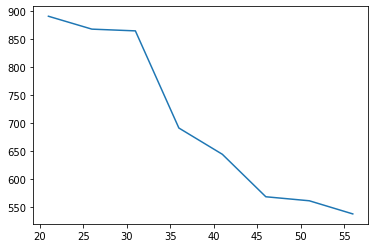

In [370]:
mlDf[mlDf['state']=='pennsylvania']['manufacturing_jobs'].plot()

<AxesSubplot:>

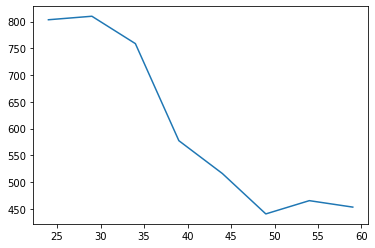

In [372]:
mlDf[mlDf['state']=='north carolina']['manufacturing_jobs'].plot()

In [369]:
showAll()
mlDf

,year,state,turnout,manufacturing_jobs,unemployment_rate,cpi_all_items,cpi_gasoline,cpi_medical_care
0,1976,florida,democrat,NaN,9.300000,56.908333,46.991667,51.991667
1,1976,pennsylvania,democrat,NaN,8.008333,56.908333,46.991667,51.991667
2,1976,ohio,democrat,NaN,7.725000,56.908333,46.991667,51.991667
3,1976,michigan,republican,NaN,9.400000,56.908333,46.991667,51.991667
4,1976,north carolina,democrat,NaN,6.191667,56.908333,46.991667,51.991667
5,1980,florida,republican,NaN,5.983333,82.408333,97.516667,74.875000
6,1980,pennsylvania,republican,NaN,8.141667,82.408333,97.516667,74.875000
7,1980,ohio,republican,NaN,8.316667,82.408333,97.516667,74.875000
8,1980,michigan,republican,NaN,12.300000,82.408333,97.516667,74.875000
9,1980,north carolina,republican,NaN,6.425000,82.408333,97.516667,74.875000


##### Goodness-of-fit tests

In [342]:
showAll(False)

In [349]:
swing = df[df['state'].isin(top5swing)].groupby(['year', 'state', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

swing['rate'] = swing['candidatevotes'] / swing['totalvotes']
swing.reset_index(inplace=True)
swing.head()

,year,state,party,candidatevotes,totalvotes,rate
0,1976,florida,democrat,1636000,3150631,0.519261
1,1976,florida,other,45100,3150631,0.014315
2,1976,florida,republican,1469531,3150631,0.466424
3,1976,michigan,democrat,1696714,3651590,0.464651
4,1976,michigan,libertarian,5407,3651590,0.001481


In [ ]:
Let theta represent the support rate for the republican party for each state in an election year 

Null: theta = 0.5  Alt: theta != 0.5 

Null: theta > 0.5  Alt: theta <= 0.5 

In [356]:
data = swing[swing['party'] == 'republican']
data 

,year,state,party,candidatevotes,totalvotes,rate
2,1976,florida,republican,1469531,3150631,0.466424
6,1976,michigan,republican,1893742,3651590,0.518608
10,1976,north carolina,republican,741960,1677906,0.442194
14,1976,ohio,republican,2000626,4110456,0.486716
17,1976,pennsylvania,republican,2205604,4620787,0.477322
...,...,...,...,...,...,...
215,2020,florida,republican,5668731,11067456,0.512198
219,2020,michigan,republican,2649852,5539302,0.478373
223,2020,north carolina,republican,2758773,5524802,0.499343
227,2020,ohio,republican,3154834,5922202,0.532713


In [363]:
top5red = ['texas', 'tennessee', 'indiana', 'missouri', 'alabama']
red = df[df['state'].isin(top5red)].groupby(['year', 'state', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

red['rate'] = red['candidatevotes'] / red['totalvotes']
red.reset_index(inplace=True)
redData = red[red['party'] == 'republican']
redData

,year,state,party,candidatevotes,totalvotes,rate
3,1976,alabama,republican,504070,1182850,0.426149
6,1976,indiana,republican,1183958,2220362,0.533227
9,1976,missouri,republican,927443,1953600,0.474735
12,1976,tennessee,republican,633969,1476346,0.429418
15,1976,texas,republican,1953300,4071884,0.479704
...,...,...,...,...,...,...
203,2020,alabama,republican,1441170,2323282,0.620316
207,2020,indiana,republican,1729519,3033118,0.570212
211,2020,missouri,republican,1718736,3025962,0.567997
214,2020,tennessee,republican,1852475,3053851,0.606603


In [364]:
redData.to_csv('data/partARedStates.csv')

In [366]:
top5blue = ['california', 'new york', 'illinois', 'massachusetts', 'maryland']

blue = df[df['state'].isin(top5blue)].groupby(['year', 'state', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'
})

blue['rate'] = blue['candidatevotes'] / blue['totalvotes']
blue.reset_index(inplace=True)
blueData = blue[blue['party'] == 'democrat']
blueData

,year,state,party,candidatevotes,totalvotes,rate
0,1976,california,democrat,3742284,7803770,0.479548
3,1976,illinois,democrat,2271295,4721282,0.481076
7,1976,maryland,democrat,759612,1432273,0.530354
9,1976,massachusetts,democrat,1429475,2547558,0.561116
13,1976,new york,democrat,3244165,6668262,0.486508
...,...,...,...,...,...,...
214,2020,california,democrat,11110250,17500881,0.634839
218,2020,illinois,democrat,3471915,6033743,0.575416
222,2020,maryland,democrat,1985023,3037030,0.653607
226,2020,massachusetts,democrat,2382202,3658005,0.651230


In [367]:
blueData.to_csv('data/partABlueStates.csv')

In [365]:
df['state'].unique()

array(['alabama', 'alaska', 'arizona', 'arkansas', 'california',
       'colorado', 'connecticut', 'delaware', 'district of columbia',
       'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana',
       'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland',
       'massachusetts', 'michigan', 'minnesota', 'mississippi',
       'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire',
       'new jersey', 'new mexico', 'new york', 'north carolina',
       'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
       'rhode island', 'south carolina', 'south dakota', 'tennessee',
       'texas', 'utah', 'vermont', 'virginia', 'washington',
       'west virginia', 'wisconsin', 'wyoming'], dtype=object)

In [28]:
# Unused code archive

# def restructureCPIData(df):
    
#     """ 
#         Reorganize the cpi datasets to combine the months and years into one
#         variable in datetime type. Each row is now associated with only one 
#         cpi number.

#     """ 

#     rowsModified = []

#     def processOneRow(row):
#         timeline, data = [], []
#         year = row['Year']

#         for m in months:
#             time = pd.to_datetime(str(year)[:-2]+' '+m)
#             datum = row[m]
#             timeline.append(time)
#             data.append(datum)
        
#         rowsModified.append(pd.DataFrame(data={'timeline':timeline,'cpi': data}))
    
#     df.apply(processOneRow, axis=1)

#     return pd.concat(rowsModified)